In [ ]:
#import packages
from statsbombpy import sb
import pandas as pd

In [1]:
from statsbombpy import sb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from collections import Counter



/Users/megheaiani/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# --- Import required packages ---
from statsbombpy import sb
import pandas as pd

# LIGUE 1 2015-2016
competition_id = 12
season_id = 27

# --- Load all match IDs for the competition and season ---
matches = sb.matches(competition_id=competition_id, season_id=season_id)
match_ids = matches['match_id'].tolist()

# --- Download all events for these matches and extract assists ---
assists_list = []
for match_id in match_ids:
    df = sb.events(match_id=match_id, flatten_attrs=True)
    # Ensure 'pass_goal_assist' exists and fill missing with False
    if 'pass_goal_assist' not in df.columns:
        df['pass_goal_assist'] = False
    else:
        df['pass_goal_assist'] = df['pass_goal_assist'].fillna(False)
    # Filter for passes that are assists
    assists = df[(df['type'] == 'Pass') & (df['pass_goal_assist'] == True)]
    assists_list.append(assists)

# --- Concatenate all assists into a single DataFrame ---
df_assists = pd.concat(assists_list, ignore_index=True)

# --- (Optional) Reset index and inspect the result ---
df_assists.reset_index(drop=True, inplace=True)
print(f"Extracted {len(df_assists)} assists from competition {competition_id}, season {season_id}")
print(df_assists[['match_id', 'minute', 'player', 'team', 'pass_length', 'pass_angle', 'pass_height', 'pass_technique']].head())


/Users/megheaiani/anaconda3/lib/python3.11/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/megheaiani/anaconda3/lib/python3.11/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/var/folders/4m/2n3yzlf10012wdm94p3176pm0000gn/T/ipykernel_56548/4029153614.py:21: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['pass_goal_assist'] = df['pass_goal_assist'].fillna(False)
/Users/megheaiani/anaconda3/lib/python3.11/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/var/folders/4m/2n3yzlf10012wdm94p3176pm0000gn/T/ipykernel_56548/40291536

Extracted 609 assists from competition 12, season 27
   match_id  minute                         player       team  pass_length  \
0   3879863       9    Ali Adnan Kadhim Al Tameemi    Udinese    29.602703   
1   3879773      11               Federico Dionisi  Frosinone    13.960659   
2   3879773      59                Daniel Pavlovic  Frosinone    43.035336   
3   3879847      11    Gastón Alexis Silva Perdomo     Torino    38.888817   
4   3879847      46  Bruno Miguel Borges Fernandes    Udinese    32.981510   

   pass_angle  pass_height pass_technique  
0    1.557284    High Pass            NaN  
1    1.020549  Ground Pass            NaN  
2    1.082206    High Pass            NaN  
3    1.838853    High Pass    Outswinging  
4    1.440048    High Pass            NaN  


/Users/megheaiani/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


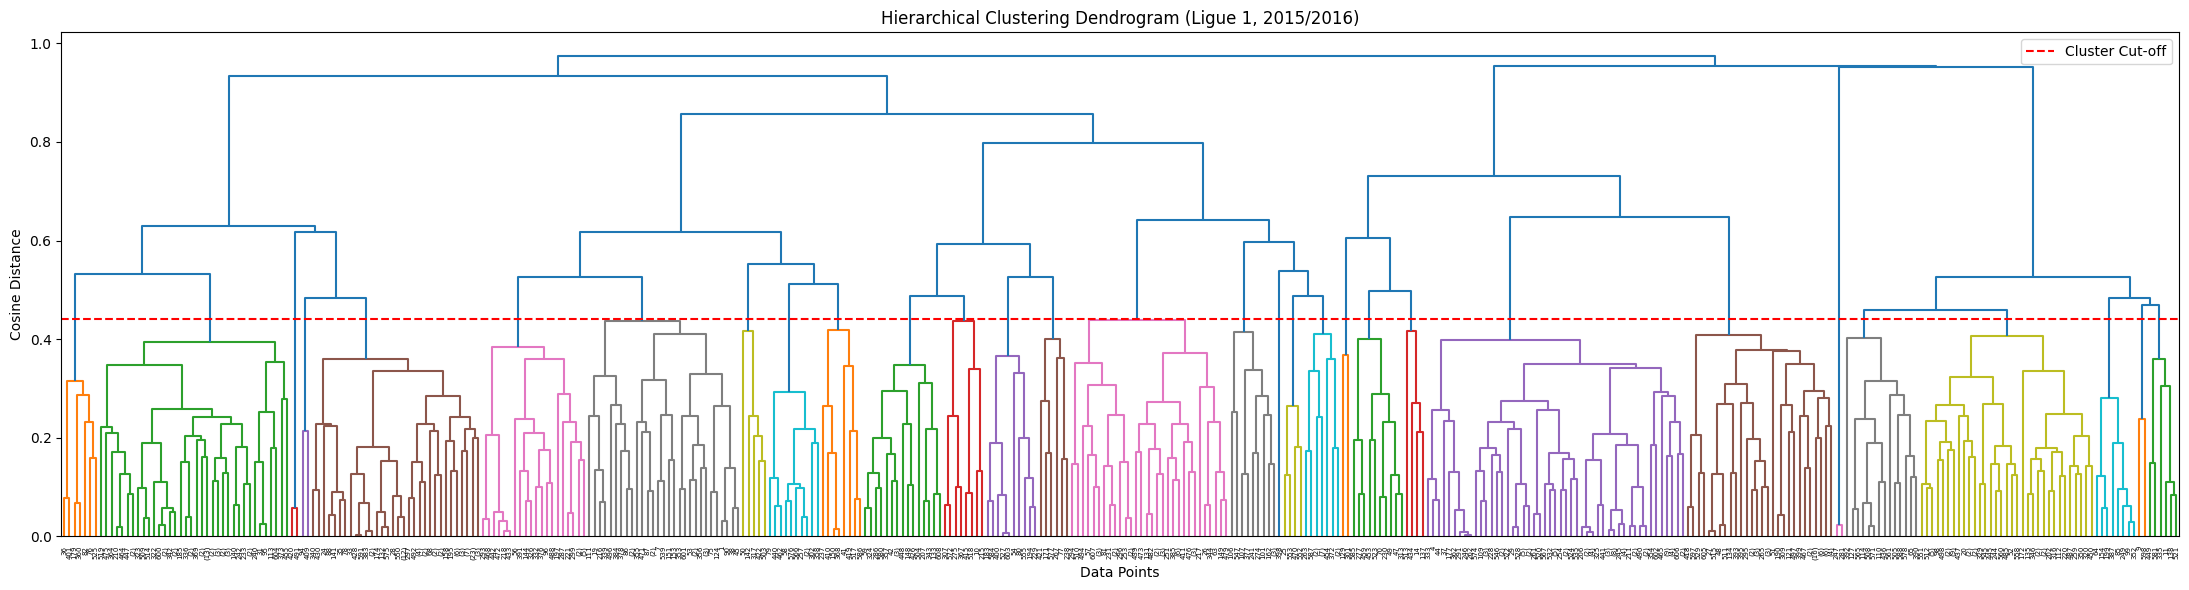

Total assists: 609
Through balls: 92 (15.1%)
High passes: 235 (38.6%)
Crosses: 178 (29.2%)
Ground passes: 303 (49.8%)


/var/folders/4m/2n3yzlf10012wdm94p3176pm0000gn/T/ipykernel_56548/1085173918.py:92: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  n_cross = df_assists['pass_cross'].fillna(False).astype(bool).sum() if 'pass_cross' in df_assists else 0


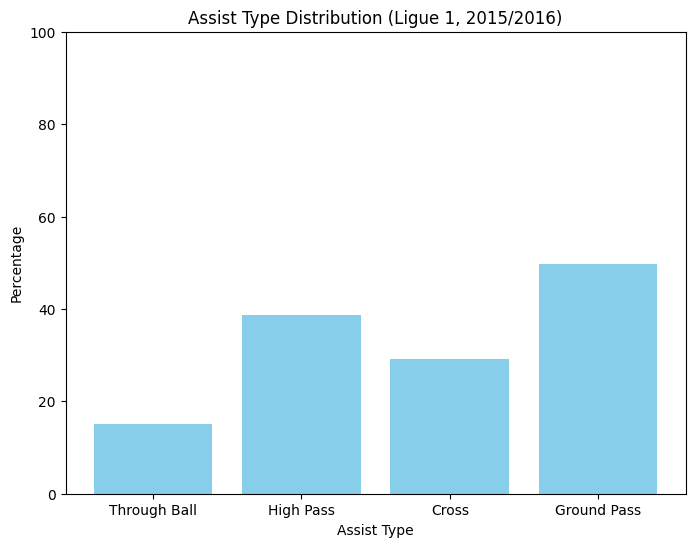

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt



for col in ['location', 'pass_end_location']:
    df_assists[col] = df_assists[col].apply(
        lambda x: x if isinstance(x, (list, tuple)) and len(x) == 2 else [np.nan, np.nan]
    )

start_loc = df_assists['location'].apply(pd.Series)
start_loc.columns = ['pass_start_x', 'pass_start_y']

end_loc = df_assists['pass_end_location'].apply(pd.Series)
end_loc.columns = ['pass_end_x', 'pass_end_y']

df_assists = pd.concat([df_assists, start_loc, end_loc], axis=1)

feature_df = pd.DataFrame({
    'pass_length': df_assists['pass_length'],
    'pass_angle': df_assists['pass_angle'],
    'pass_height': df_assists['pass_height'],
    'pass_deflected': df_assists['pass_deflected'].fillna(0).astype(int),
    'under_pressure': df_assists['under_pressure'].fillna(0).astype(int),
    'pass_start_x': df_assists['pass_start_x'],
    'pass_start_y': df_assists['pass_start_y'],
    'pass_end_x': df_assists['pass_end_x'],
    'pass_end_y': df_assists['pass_end_y'],
    'pass_body_part': df_assists['pass_body_part'],
    'pass_technique': df_assists['pass_technique'],
    'play_pattern': df_assists['play_pattern'],
})

height_map = {'Ground Pass': 0, 'Low Pass': 1, 'High Pass': 2}
feature_df['pass_height'] = feature_df['pass_height'].map(height_map)

categorical = ['pass_body_part', 'pass_technique', 'play_pattern']
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoded = encoder.fit_transform(feature_df[categorical].fillna('Unknown'))
encoded_cols = encoder.get_feature_names_out(categorical)
encoded_df = pd.DataFrame(encoded, columns=encoded_cols, index=feature_df.index)

numerical = ['pass_length', 'pass_angle', 'pass_height', 'pass_deflected', 'under_pressure',
             'pass_start_x', 'pass_start_y', 'pass_end_x', 'pass_end_y']
scaler = StandardScaler()
scaled = scaler.fit_transform(feature_df[numerical])
scaled_df = pd.DataFrame(scaled, columns=numerical, index=feature_df.index)

X = pd.concat([scaled_df, encoded_df], axis=1)
X = X.fillna(0)

linked = linkage(X, method='average', metric='cosine')

plt.figure(figsize=(22, 6))
dendrogram(
    linked,
    truncate_mode="level", p=10,
    color_threshold=0.44
)
plt.axhline(y=0.44, color='r', linestyle='--', label="Cluster Cut-off")
plt.title('Hierarchical Clustering Dendrogram (Ligue 1, 2015/2016)')
plt.xlabel('Data Points')
plt.ylabel('Cosine Distance')
plt.legend()
plt.tight_layout()
plt.show()

cluster_labels = fcluster(linked, t=0.44, criterion='distance')
feature_df['cluster'] = cluster_labels

total = len(df_assists)
def pct(val): return 100 * val / total if total else 0

n_through = df_assists['pass_technique'].fillna('').str.contains('Through Ball').sum()
pct_through = pct(n_through)

n_high = df_assists['pass_height'].eq('High Pass').sum()
pct_high = pct(n_high)

n_cross = df_assists['pass_cross'].fillna(False).astype(bool).sum() if 'pass_cross' in df_assists else 0
pct_cross = pct(n_cross)

n_ground = df_assists['pass_height'].eq('Ground Pass').sum()
pct_ground = pct(n_ground)

print(f"Total assists: {total}")
print(f"Through balls: {n_through} ({pct_through:.1f}%)")
print(f"High passes: {n_high} ({pct_high:.1f}%)")
print(f"Crosses: {n_cross} ({pct_cross:.1f}%)")
print(f"Ground passes: {n_ground} ({pct_ground:.1f}%)")

labels = ['Through Ball', 'High Pass', 'Cross', 'Ground Pass']
sizes = [pct_through, pct_high, pct_cross, pct_ground]

plt.figure(figsize=(8,6))
plt.bar(labels, sizes, color='skyblue')
plt.title('Assist Type Distribution (Ligue 1, 2015/2016)')
plt.ylabel('Percentage')
plt.xlabel('Assist Type')
plt.ylim(0, 100)
plt.show()
